In [1]:
import numpy as np
import matplotlib.pyplot as plt

import itertools
import time
import os

import glob

from natsort import natsorted
from IPython.display import clear_output, display

from tqdm.auto import tqdm

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [2]:
fblocks = np.array([
    [(0,0,0),(1,0,1),(2,0,0),(3,0,1),(4,0,0)],
    [(0,0,0),(1,0,1),(2,0,0),(2,-1,1),(1,1,0)],
    [(0,0,0),(1,0,1),(2,0,0),(0,1,1),(2,-1,1)],
    [(0,0,0),(1,0,1),(2,0,0),(-1,0,1),(0,-1,1)],
    [(0,0,0),(-1,0,1),(1,0,1),(0,1,1),(0,-1,1)],
    [(0,0,1),(1,0,0),(2,0,1),(0,1,0),(0,-1,0)],
    [(0,0,0),(1,0,1),(2,0,0),(3,0,1),(0,1,1)],
    [(0,0,0),(0,1,1),(2,0,0),(2,1,1),(1,1,0)],
    [(0,0,1),(1,0,0),(2,0,1),(0,1,0),(0,2,1)],
    [(0,0,1),(-1,0,0),(0,1,0),(1,1,1),(2,1,0)],
    [(0,0,0),(1,0,1),(0,1,1),(1,1,0),(-1,1,0)],
    [(0,0,0),(1,0,1),(0,1,1),(1,1,0)],
    [(0,0,0),(1,1,0),(2,2,0),(0,1,1),(1,2,1)]
])


board_size = 8

#fblocks = np.array([
#    [(0,0,0)],
#    [(0,0,0),(-1,0,1),(0,-1,1)],
#    [(0,0,0),(0,1,1),(0,2,0),(0,3,1)],
#    [(0,0,0),(-1,0,1),(0,-1,1),(0,-2,0)],
#    [(0,0,1),(-1,0,0),(0,-1,0),(0,-2,1)],
#    [(0,0,0),(0,1,1),(0,2,0),(0,3,1)],
#    [(0,0,0),(0,1,1),(0,2,0)],
#    [(0,0,1),(0,1,0)]
#])
#
#board_size = 5

blocks = []
for block in fblocks:
    blocks.append(np.array(block))
fblocks = np.array(blocks).copy()

dcol = np.random.rand(len(fblocks),3)

In [3]:
def rotation(block, rot=0):
    block = block.copy()
    rblock = block[...,:-1]
    if rot==0:
        rblock = np.array(list(map(lambda x : [x[0],x[1]], rblock)))
    elif rot==1:
        rblock = np.array(list(map(lambda x : [x[1],-x[0]], rblock)))
    elif rot==2:
        rblock = np.array(list(map(lambda x : [-x[0],-x[1]], rblock)))
    else:
        rblock = np.array(list(map(lambda x : [-x[1],x[0]], rblock)))
    block[...,:-1] = rblock
    return block

def translation(block, vector):
    block = block.copy()
    rblock = block[...,:-1]
    rblock = np.array(list(map(lambda x : x + vector, rblock)))
    block[...,:-1] = rblock
    return block

def mirroring(block, mirror):
    block = block.copy()
    rblock = block[...,:-1]
    if mirror:
        rblock = np.array(list(map(lambda x : [-x[0],x[1]], rblock)))
    block[...,:-1] = rblock
    return block

In [4]:
def move_block(block, setting):
    block = mirroring(block,setting[-1])
    block = rotation(block,setting[-2])
    block = translation(block,setting[:-2])
    return block

def move_blocks(gnome):
    return np.array([move_block(block, all_combs[gene]) for block, gene in zip(fblocks, gnome)])

def plot_block(block, setting = [0,0,0,0], *args, **kwargs):
    block = move_block(block, setting)
    mask = block[...,-1] == 0
    plt.plot(block[mask,0], block[mask,1], marker='s', fillstyle='top', linewidth=0, *args, **kwargs)
    plt.plot(block[~mask,0], block[~mask,1], marker='s', fillstyle='bottom', linewidth=0, *args, **kwargs)
    
def plot_blocks(blocks, settings = None, filename = None, *args, **kwargs):
    fig = plt.figure(figsize=(10,10))
    edges = np.array([[0,0], [0,board_size-1], [board_size-1,board_size-1], [board_size-1,0], [0,0]])
    plt.plot(edges[:,0], edges[:,1], color='r')
    for idx,block in enumerate(blocks):
        setting = [0,0,0,0] if settings is None else settings[idx]
        plot_block(block, setting, markersize=40, color = dcol[idx])
    plt.xlim(-1, board_size)
    plt.ylim(-1, board_size)
    
    if filename is not None:
        plt.savefig(f'images/{filename}', bbox_inches='tight', dpi=100)
        plt.close(fig)

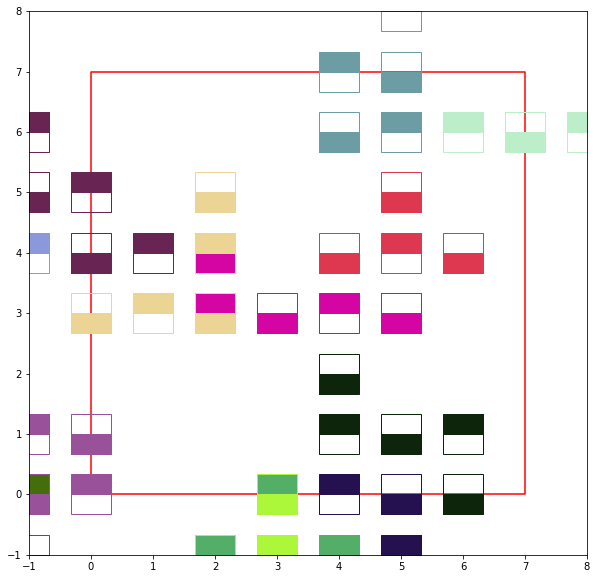

In [5]:
vecs = [np.random.randint(-1,board_size,2) for i in range(len(fblocks))]
rots = [np.random.randint(0,4) for i in range(len(fblocks))]
mirrs = [np.random.randint(0,1) for i in range(len(fblocks))]

settings = [(*vec, rot, mirr) for vec,rot,mirr in zip(vecs,rots,mirrs)]

plot_blocks(fblocks, settings)

In [7]:
# brute force it
brute_positions_x = np.array(list(range(board_size)))
brute_positions_y = brute_positions_x
brute_rotations = np.array(list(range(4)))
brute_mirrors = np.array(list(range(2)))

iterables = [brute_positions_x, brute_positions_y, brute_rotations, brute_mirrors]

all_combs = np.array(list(itertools.product(*iterables)))

In [8]:
def board_count(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks, axis=0)
    
    edges = [any(coord < 0 for coord in block) or any(coord >= board_size for coord in block) for block in flats]
    return np.count_nonzero(edges)
    

def duplication_count(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks)
    mat = np.zeros((board_size, board_size))
    for pos in flats:
        x, y = pos
        if x < 0 or x >= board_size or y < 0 or y >= board_size:
            continue
        mat[pos[0]][pos[1]] += 1
        
    nflats = mat.ravel()
    dcount = 0
    for n in nflats:
        if n > 1:
            dcount += n
            
    return int(dcount)

def single_check(case):
        if np.sum(case[:-1]) % 2 != case[-1]:
            return False
        return True

def fillstyle_count(blocks):
    flats = np.concatenate(blocks, axis=0)
    dcount = 0
    for case in flats:
        if not single_check(case):
            dcount += 1
    return dcount

def fitness_function(blocks):
    return board_count(blocks) + duplication_count(blocks) + fillstyle_count(blocks)

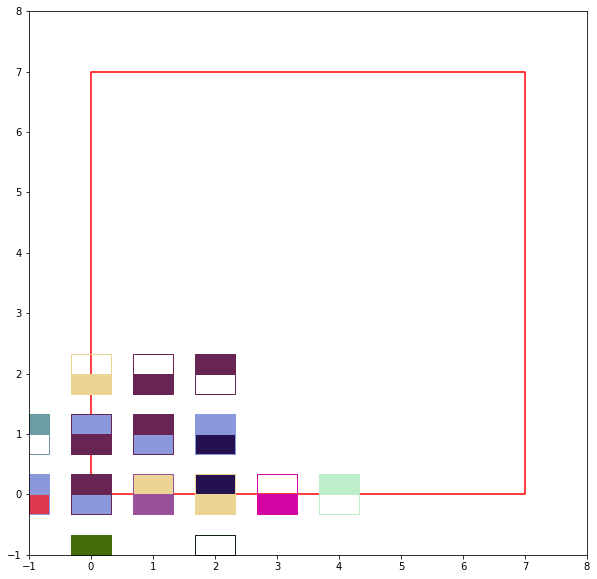

In [9]:
plot_blocks(fblocks)

In [10]:
# Number of individuals in each generation 
NPOP = 50
NGENES = len(all_combs)
NGNOMES = len(fblocks)

class Individual(object): 
    ''' 
    Class representing individual in population 
    '''
    def __init__(self, chromosome): 
        self.chromosome = np.array(chromosome)
        self.fitness = self.cal_fitness() 

    @classmethod
    def mutated_genes(self): 
        ''' 
        create random genes for mutation 
        '''
        return np.random.randint(0,NGENES)

    @classmethod
    def create_gnome(self): 
        ''' 
        create chromosome or string of genes 
        '''
        return np.random.randint(0, NGENES, NGNOMES)
    
    @staticmethod
    def swap_genes(chromosome, pair_swap):
        '''
        switch two genes in the chromosome
        '''
        gnome = chromosome.copy()
        gnome[pair_swap] = gnome[np.flip(pair_swap)]
        return gnome        

    def mate(self, par2): 
        ''' 
        Perform mating and produce new offspring 
        '''
        # chromosome for offspring 
        child_chromosome = []
        prob = np.random.rand(len(fblocks))
        for g1, g2, p in zip(self.chromosome, par2.chromosome, prob): 
            if p < 0.45:
                child_chromosome.append(g1)
            elif p < 0.9:
                child_chromosome.append(g2)
            else:
                child_chromosome.append(self.mutated_genes())
        child_chromosome = np.array(child_chromosome)
                
        # do random swap of genes
        for _ in range(int(np.random.exponential(2))):
            swap_pair = np.random.randint(0, len(fblocks), 2)
            child_chromosome = self.swap_genes(child_chromosome, swap_pair)

        # create new Individual(offspring) using 
        # generated chromosome for offspring 
        return Individual(child_chromosome) 

    def cal_fitness(self): 
        ''' 
        Calculate fittness score, it is the number of 
        characters in string which differ from target 
        string. 
        '''
        blocks = move_blocks(self.chromosome)
        return fitness_function(blocks)

In [10]:
# Driver code 
def main():

    #current generation 
    generation = 1

    found = False
    population = [Individual(Individual.create_gnome()) for i in range(int(NPOP))]

    while not found: 
        population = sorted(population, key = lambda x:x.fitness) 

        # if the individual having lowest fitness score ie. 
        # 0 then we know that we have reached to the target 
        # and break the loop 
        if population[0].fitness <= 0: 
            found = True
            break

        # Otherwise generate new offsprings for new generation 
        new_generation = [] 

        # Perform Elitism, that mean 10% of fittest population 
        # goes to the next generation 
        s1, s2, s3 = int(0.1*NPOP), int(0.5*NPOP), int(0.4*NPOP) 
        new_generation.extend(population[:s1]) 

        for _ in range(s2): 
            parent1 = np.random.choice(population[:int(0.5*NPOP)]) 
            parent2 = np.random.choice(population[:int(0.5*NPOP)]) 
            child = parent1.mate(parent2) 
            new_generation.append(child) 
            
        new_generation.extend([Individual(Individual.create_gnome()) for i in range(s3)])
        population = new_generation 

        if generation % 10 == 0:
            print("Generation: {}\tChromosome: {}\tFitness: {}".format(generation, ','.join([str(x) for x in population[0].chromosome]), population[0].fitness), flush=True) 

        generation += 1
    return population[0]

In [17]:
res = Individual([6,91,334,133,232,499,378,176,454,211,419,48,72])
res = Individual([459,50,178,120,382,198,390,18,159,303,345,277,363])
res = Individual([133,23,511,91,346,314,460,403,61,212,238,363,144])
res = Individual([35,417,349,110,22,195,508,404,449,296,165,255,3])

In [18]:
res.fitness

2

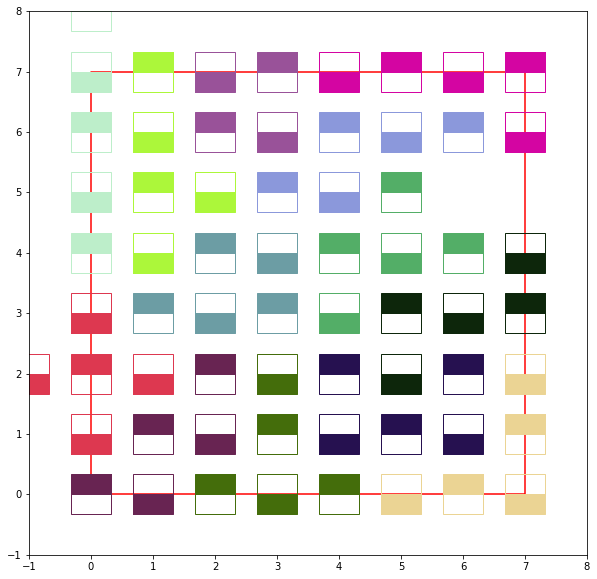

In [19]:
#plot_blocks(move_blocks(result[0].chromosome))
plot_blocks(move_blocks(res.chromosome))